# k-means

$$
d(\boldsymbol{x}^{(i)}, \boldsymbol{\mu}^{(j)})^2 = \left\| \boldsymbol{x^{(i)}} - \boldsymbol{\mu}^{(j)} \right\|^2
$$

## 問題設定

与えられたデータセットを $$k$$ 個のクラスタに分割する。


## 処理の流れ

1. 与えられたデータセット $$\boldsymbol{x}^{(1)}, \cdots, \boldsymbol{x}^{(n)}$$ のうち $$k$$ 個を **セントロイド** としてランダムに選択
    - 以後、セントロイドは $$\boldsymbol{\mu}^{(1)}, \cdots, \boldsymbol{\mu}^{(k)}$$ で表す
    - セントロイド $$\boldsymbol{\mu}^{(j)}$$ は $$j$$ 番目のクラスタ $$C^{(j)}$$ に対応する
2. 各データサンプル $$\boldsymbol{x}^{(i)}$$ に対して、各セントロイド $$\boldsymbol{\mu}^{(j)}$$ からのユークリッド距離 $$d(\boldsymbol{x}^{(i)}, \boldsymbol{\mu}^{(j)})$$ を計算
    - $$d(\boldsymbol{x}^{(i)}, \boldsymbol{\mu}^{(j)})^2 = \left\| \boldsymbol{x^{(i)}} - \boldsymbol{\mu}^{(j)} \right\|^2$$
3. 各データサンプルを、距離が一番近いセントロイド（に対応するクラスタ）に所属させる
4. 各クラスタに所属する全データの重心（平均）を取り、それを新しいセントロイドとする
    - $$\boldsymbol{\mu}^{(j)} \longleftarrow \cfrac{1}{|C^{(j)}|} \displaystyle \sum_{\boldsymbol{x}^{(i)} \in C^{(j)}} \boldsymbol{x}^{(i)}$$

## 注意

- ユークリッド距離を用いるため、変数のスケールを事前に揃えておく必要がある
- はじめにハイパーパラメータ $$k$$ を指定する必要があり、適切な $$k$$ を選ばないと性能が悪くなる


In [165]:
import numpy as np

class KMeans:
    """
    Attributes
    ----------
    k : int
        データセットをいくつのクラスタに分割するか
    max_trial : int
        イテレーションの最大回数
    cluster : numpy array
        各データサンプルが属するクラスタ番号
    mu : numpy array
        各クラスタのセントロイド
    sse : float
        クラスタ内誤差平方和 (SSE)
    """
    
    def __init__(self, k, max_trial):
        self.k = k
        self.max_trial = max_trial
    
    def fit(self, data):
        n = len(data)
        dim = len(data[0])
        mu = data[np.random.choice(range(n), self.k, replace=False)]
        for t in range(self.max_trial):
            cluster = np.zeros(n, dtype=int)
            cluster_size = np.zeros(self.k)
            cluster_sum = np.zeros([self.k, dim])
            for i in range(n):
                d_sq_min = np.inf
                for j in range(self.k):
                    d_sq = np.sum((data[i] - mu[j])**2)
                    if d_sq < d_sq_min:
                        d_sq_min = d_sq
                        cluster[i] = j
                cluster_size[cluster[i]] += 1
                cluster_sum[cluster[i]] += data[i]
            mu_next = (cluster_sum.T / cluster_size).T
            if np.all(mu == mu_next):
                print('Converged in {} cycles'.format(t))
                break
            mu = mu_next
        self.cluster = cluster
        self.mu = mu
        self.sse = self.__calc_sse(data)
    
    def __calc_sse(self, data):
        """
        クラスタ内誤差平方和 (SSE) の計算
        """
        sse = 0
        for i in range(len(data)):
            sse += np.sum((data[i] - self.mu[self.cluster[i]])**2)
        return sse

In [166]:
%matplotlib inline
from matplotlib import pyplot as plt

def plot_kmeans(km_, data_):
    colors = ['red', 'blue', 'green', 'orange']
    for c in range(km_.k):
        data_c = data_[np.where(km_.cluster == c)[0]]
        plt.scatter(data_c[:, 0], data_c[:, 1], s=20, marker='x', c=colors[c], label='Cluster {}'.format(c))
        plt.scatter(km_.mu[c][0], km_.mu[c][1], s=80, c=colors[c])
    plt.legend()
    plt.show()

Converged in 6 cycles


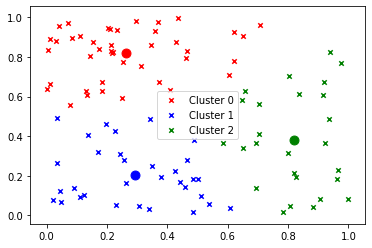

In [168]:
N = 100
x = np.random.rand(N)
y = np.random.rand(N)
data = np.array([x, y]).T

km = KMeans(3, 100)
km.fit(data)

plot_kmeans(km, data)

Converged in 13 cycles


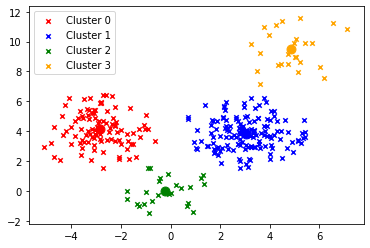

In [182]:
def circle(c_, R_, n_):
    r = R_ * np.random.rand(n_)
    theta = np.random.rand(n_) * 2 * np.pi
    data = np.array([r * np.sin(theta) + c_[0], r * np.cos(theta) + c_[1]]).T
    return data

N = 300
data1 = circle([0, 0], 2, N//12)
data2 = circle([-3, 4], 2.5, N//3)
data3 = circle([3, 4], 2.5, N//2)
data4 = circle([5, 9], 3, N//12)
data = np.concatenate([data1, data2, data3, data4])

km = KMeans(4, 100)
km.fit(data)

plot_kmeans(km, data)

# FCM

$$
w^{(i,j)} = \left\{ \displaystyle \sum_{c=1}^k \left( \frac{\left\| \boldsymbol{x^{(i)}} - \boldsymbol{\mu}^{(j)} \right\|^2}{\left\| \boldsymbol{x^{(i)}} - \boldsymbol{\mu}^{(c)} \right\|^2} \right)^{\frac{1}{m-1}} \right\}^{-1}
$$

$$
\boldsymbol{\mu}^{(j)} \longleftarrow \displaystyle \cfrac{\sum_{i=1}^n \left(w^{(i,j)}\right)^m \boldsymbol{x}^{(i)}}{\sum_{i=1}^n \left(w^{(i,j)}\right)^m}
$$

In [190]:
class FCM:
    """
    Attributes
    ----------
    k : int
        データセットをいくつのクラスタに分割するか
    m : int
        ファジー係数 ( > 1)
    max_trial : int
        イテレーションの最大回数
    cluster : numpy array
        各データサンプルが各クラスタに属する確率の二次元配列
    mu : numpy array
        各クラスタのセントロイド
    sse : float
        クラスタ内誤差平方和 (SSE)
    """
    
    def __init__(self, k, m, max_trial):
        self.k = k
        self.m = m
        self.max_trial = max_trial
    
    def fit(self, data):
        n = len(data)
        dim = len(data[0])
        w = np.random.rand(n, self.k)
        mu = self.__calc_centroid(w, data)
        for t in range(self.max_trial):
            for i in range(n):
                d_sq_list = np.array([np.sum((data[i] - mu[j])**2) for j in range(self.k)])
                w[i] = np.array([1/np.sum(np.power(d_sq_list[j]/d_sq_list, 1/(self.m-1))) for j in range(self.k)])
            mu_next = self.__calc_centroid(w, data)
            if np.all(mu == mu_next):
                print('Converged in {} cycles'.format(t))
                break
            mu = mu_next
        self.cluster = w
        self.mu = mu
        self.sse = self.__calc_sse(data)
    
    def __calc_centroid(self, w, data):
        return np.array([np.sum(w[:, j]**self.m * data.T, axis=1)/np.sum(w[:, j]**self.m) for j in range(self.k)])
    
    def __calc_sse(self, data):
        """
        クラスタ内誤差平方和 (SSE) の計算
        """
        sse = 0
        for i in range(len(data)):
            for j in range(self.k):
                sse += self.cluster[i][j] * np.sum((data[i] - self.mu[j])**2)
        return sse

In [158]:
%matplotlib inline
from matplotlib import pyplot as plt

def plot_fcm(fcm_, data_):
    """
    クラスタ数が3であることを前提に、RGB カラーの濃度でクラスタへの所属確率を表現
    """
    plt.title('fuzzy coefficient $m = {}$'.format(fcm_.m))
    for i in range(len(data_)):
        color = (fcm_.cluster[i][0], fcm_.cluster[i][1], fcm_.cluster[i][2])
        plt.scatter([data[i][0]], [data[i][1]], color=color)
    plt.scatter([], [], color=(1, 0, 0), label='Cluster 1')
    plt.scatter([], [], color=(0, 1, 0), label='Cluster 2')
    plt.scatter([], [], color=(0, 0, 1), label='Cluster 3')
    plt.legend()

Converged in 40 cycles
Converged in 50 cycles


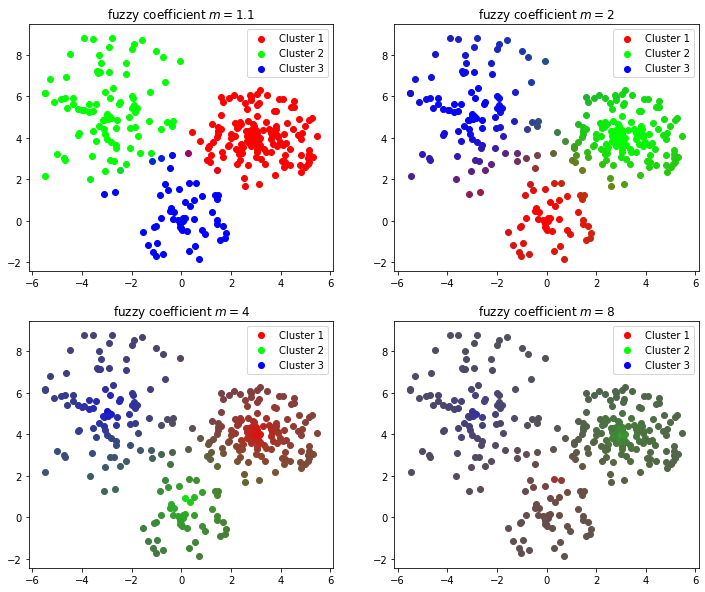

In [163]:
def circle(c_, R_, n_):
    r = R_ * np.random.rand(n_)
    theta = np.random.rand(n_) * 2 * np.pi
    data = np.array([r * np.sin(theta) + c_[0], r * np.cos(theta) + c_[1]]).T
    return data

N = 300
data1 = circle([0, 0], 2, N//6)
data2 = circle([-3, 5], 4, N//3)
data3 = circle([3, 4], 2.5, N//2)
data = np.concatenate([data1, data2, data3])


m_list = [1.1, 2, 4, 8]
plt.figure(figsize=(12, 10))
for i in range(len(m_list)):
    fcm = FCM(3, m_list[i], 100)
    fcm.fit(data)
    plt.subplot(2, 2, i+1)
    plot_fcm(fcm, data)
plt.show()
#print(np.sum(fcm.cluster, axis=1))

# エルボー法

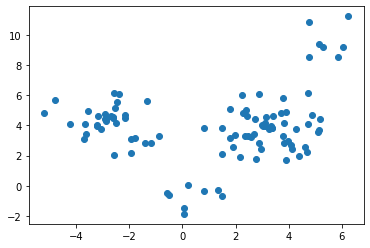

Converged in 1 cycles
Converged in 3 cycles
Converged in 4 cycles
Converged in 9 cycles
Converged in 7 cycles
Converged in 8 cycles
Converged in 9 cycles
Converged in 5 cycles
Converged in 5 cycles


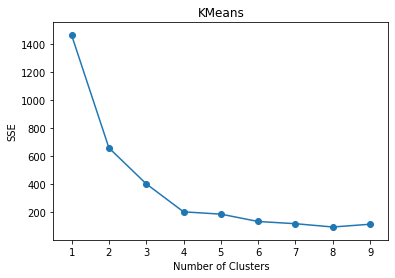

Converged in 1 cycles


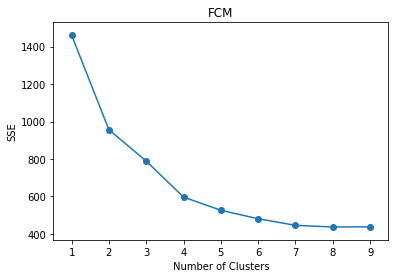

In [196]:
def circle(c_, R_, n_):
    r = R_ * np.random.rand(n_)
    theta = np.random.rand(n_) * 2 * np.pi
    data = np.array([r * np.sin(theta) + c_[0], r * np.cos(theta) + c_[1]]).T
    return data

N = 100
data1 = circle([0, 0], 2, N//12)
data2 = circle([-3, 4], 2.5, N//3)
data3 = circle([3, 4], 2.5, N//2)
data4 = circle([5, 9], 3, N//12)
data = np.concatenate([data1, data2, data3, data4])
plt.scatter(data[:, 0], data[:, 1])
plt.show()

# エルボー法
k_list = list(range(1, 10))
sse = []
for k in k_list:
    km = KMeans(k, 100)
    km.fit(data)
    sse.append(km.sse)
plt.title('KMeans')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.plot(k_list, sse)
plt.scatter(k_list, sse)
plt.show()

sse = []
for k in k_list:
    fcm = FCM(k, 2, 100)
    fcm.fit(data)
    sse.append(fcm.sse)
plt.title('FCM')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.plot(k_list, sse)
plt.scatter(k_list, sse)
plt.show()